# Detecter les plaques d'immatriculation des vehicules

## Import packages

In [1]:
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader
from customDataset import CustomDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.nn.init as init
import torch.optim as optim
from tqdm import tqdm
import torch.nn as nn
import numpy as np
import random
import torch
import math
import cv2



# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"runnning on {device}")

Random Seed:  999
runnning on cpu


## Preparing the dataset

In [2]:
image_folders = [
    r"..\..\data\images\cars\fr",
    r"..\..\data\images\cars\de",
    r"..\..\data\images\cars\pl",
]
batch_size = 8
image_size = 416
max_objects = 1
dataset = CustomDataset(image_folders=image_folders, max_objects=max_objects, image_size=image_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
len(dataloader), len(dataset)

(150, 1200)

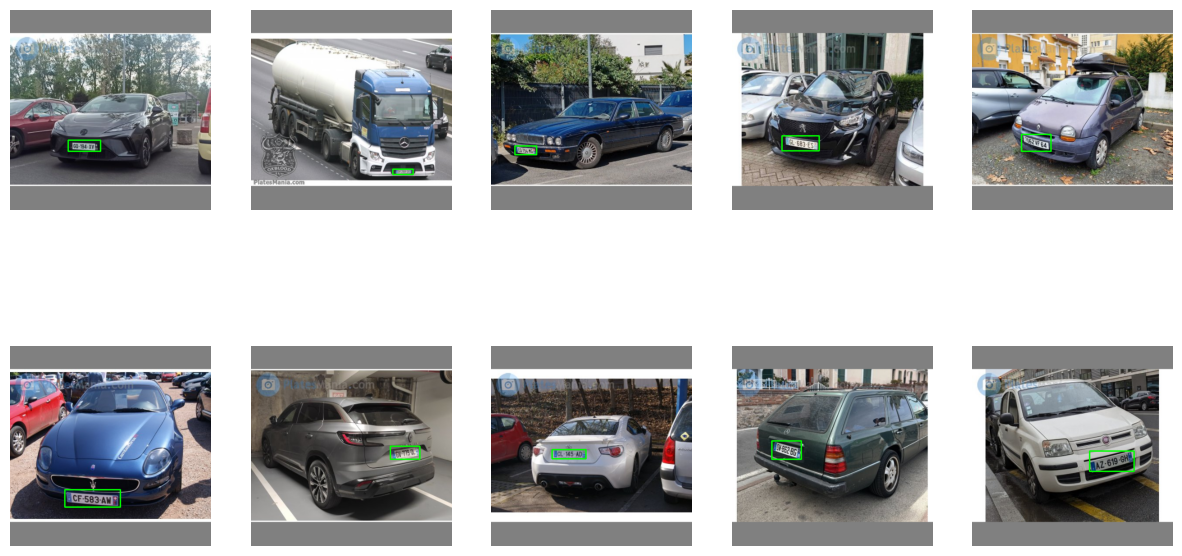

In [12]:
# Affichage de 10 images avec leurs boîtes englobantes annotées
num_images_to_display = 10
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
for i, ith_dataset in enumerate(np.random.randint(low=0, high=len(dataset), size=num_images_to_display)):
    sample = dataset[ith_dataset]
    image = sample["original_img"]
    labels = sample["label"]
    for bbox in labels:
        # Coordonnées x_min, y_min, largeur, hauteur
        x_min = int((bbox[1] - bbox[3] / 2) * image.shape[1])
        y_min = int((bbox[2] - bbox[4] / 2) * image.shape[0])
        width = int(bbox[3] * image.shape[1])
        height = int(bbox[4] * image.shape[0])
        # Dessiner la boîte englobante sur l'image
        cv2.rectangle(
            image, (x_min, y_min), (x_min + width, y_min + height), (0, 255, 0), 2
        )
    # Afficher l'image avec les boîtes englobantes annotées
    axes[i // 5, i % 5].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[i // 5, i % 5].axis("off")
plt.show()

In [9]:
for i_batch, sample_batched in enumerate(dataloader):
    input_images_batch, label_batch = (
        sample_batched["input_img"],
        sample_batched["label"],
    )
    print(i_batch, ", input_images_batch.shape =", input_images_batch.shape, ", label_batch.shape =", label_batch.shape)
    if i_batch == 3:
        break

0 , input_images_batch.shape = torch.Size([8, 3, 416, 416]) , label_batch.shape = torch.Size([8, 1, 5])
1 , input_images_batch.shape = torch.Size([8, 3, 416, 416]) , label_batch.shape = torch.Size([8, 1, 5])
2 , input_images_batch.shape = torch.Size([8, 3, 416, 416]) , label_batch.shape = torch.Size([8, 1, 5])
3 , input_images_batch.shape = torch.Size([8, 3, 416, 416]) , label_batch.shape = torch.Size([8, 1, 5])


## Building the network

In [14]:
num_bboxes = 1


class YOLO(nn.Module):
    def __init__(self, num_bboxes=2):
        super(YOLO, self).__init__()
        # Couches de convolution pour extraire les caractéristiques de l'image
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),

            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1),
        )
        # Couches entièrement connectées pour prédire les bounding boxes
        self.fc = nn.Sequential(
            nn.Linear(13 * 13 * 256, 1024),
            nn.LeakyReLU(0.1),
            nn.Dropout(),
            nn.Linear(1024, 13 * 13 * (num_bboxes * 5)),
            nn.Sigmoid(),
        )
        # Initialisation des poids
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


# Test taille du reseau
# net = YOLO(num_bboxes=num_bboxes)
# input_data = torch.randn(1, 1, image_size, image_size)
# output_data = net(input_data)
# print("La taille de sortie :", output_data.size())
# Instanciation du modèle
model = YOLO(num_bboxes=num_bboxes).to(device)
print(model)

YOLO(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.1)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.1)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(128, ep

## Training the model

In [ ]:
# Optimiseur
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Boucle d'entraînement
num_epochs = 5
train_losses = []
n_batch = len(dataloader)
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    print(f"Epoch {epoch+1}...")
    for batch_data in tqdm(dataloader, total=n_batch):
        images = batch_data[0].to(device)
        annotations = batch_data[1].to(device)
        # Réinitialiser les gradients
        optimizer.zero_grad()
        # Propagation avant
        predictions = model(images)
        # Calcul de la perte
        loss = criterion(annotations, predictions)
        # Rétropropagation
        loss.backward()
        # Mise à jour des poids
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= n_batch
    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], loss: {epoch_loss:.4f}")

In [ ]:
import numpy as np
np.sqrt(predictions.shape[1]/5)

In [ ]:
l = 0
grid_size = 13
for i in range(grid_size):
    for j in range(grid_size):
        start_index = (i * grid_size + j) * 5
        end_index = start_index + 4
        criterion(annotations[i, :4], predictions[i, start_index:end_index])

In [ ]:
target_box

In [ ]:
predictions[:, :5].shape

In [ ]:
annotations.shape

## Evaluating the model's Performance

In [ ]:
# Create a new figure for plotting
fig = plt.figure()

# Plot training losses as a blue line
plt.plot(train_losses, color="blue", marker="o")
plt.grid(True)

# Add legend and labels
plt.legend(["Train Loss"], loc="upper right")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# Display the plot
plt.show()

In [ ]:
batch_images, batch_annotations = next(iter(dataloader))
model.eval()
with torch.no_grad():
    predictions = model(batch_images)
print("MSE :", criterion(predictions, batch_annotations).item())

In [ ]:
# Affichage des images
n=2
fig, axes = plt.subplots(n, len(batch_images)//n, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    if i == len(batch_images) :
        break
    image = TF.to_pil_image(batch_images[i])
    ax.imshow(image, cmap='gray')
    ax.axis("off")
    # Dessiner les bounding boxes
    annotation = batch_annotations[i]
    annotation_pred = predictions[i]
    x_min_pred, y_min_pred, x_max_pred, y_max_pred = annotation_pred[:4].tolist()
    x_min, y_min, x_max, y_max = annotation.tolist()
    rect = plt.Rectangle(
        (x_min, y_min), x_max - x_min, y_max - y_min, edgecolor="g", facecolor="none"
    )
    rect_pred = plt.Rectangle(
        (x_min_pred, y_min_pred), x_max_pred - x_min_pred, y_max_pred - y_min_pred, edgecolor="r", facecolor="none"
    )
    ax.add_patch(rect)
    ax.add_patch(rect_pred)
    c = criterion(annotation_pred.unsqueeze(0), annotation.unsqueeze(0))
    ax.set_title(f"MSE={c.item():.2f}")
plt.tight_layout()
plt.show()